# Run Monte Carlo Simulation in Brightway

Now we are ready to start doing more intense simulations. In particular Brightway2.5 is great to perform fast error propagation with Monte Carlo simulation. 

This script shows how to add uncertainties to your home-made product system and run a Monte Carlo simulation. 

To better understand this script, I recommend reading read the paper by Limpert et al. (2001), that is a 'classic' and explains the log-normal distribution.

_Limpert, E., Stahel, W. A., & Abbt, M. (2001). Log-normal distributions across the sciences: Keys and clues. Bioscience, 51(5), 341-352. [https://doi.org/10.1641/0006-3568(2001)051[0341:LNDATS]2.0.CO;2](https://academic.oup.com/bioscience/article/51/5/341/243981)_

In [1]:
# Import brightway2.5 packages
import bw2calc as bc
import bw2data as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bd.projects.set_current('advlca23')

In [3]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.9.1 conseq
	exldb

A short recap from yesterday, let's create a database and run LCA calcualtions

In [4]:
t_db = bd.Database('testdb')

t_db.write({  # A simplified version, only CO2 as emission
    ('testdb', 'Electricity production'): {
        'name': 'Electricity production',
        'unit': 'kWh',
        'location': 'GLO',
        'exchanges': [{
                'input': ('testdb', 'Fuel production'),
                'amount': -2,
                'unit': 'kg',
                'type': 'technosphere'
            }, {
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 1,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Electricity production'),
                'amount': 10,
                'unit': 'kWh',
                'type': 'production'
            }]
        },
    ('testdb', 'Fuel production'): {
        'name': 'Fuel production',
        'unit': 'kg',
        'location': 'GLO',
        'exchanges': [{
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 10,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Fuel production'),
                'amount': 100,
                'unit': 'kg',
                'type': 'production'
            }]
    },
    ('testdb', 'Carbon dioxide'): {'name': 'Carbon dioxide', 'unit': 'kg', 'type': 'biosphere'}
    })


myLCIAdata = [[('testdb', 'Carbon dioxide'), 1.0]]
method_key = ('simplemethod', 'imaginaryendpoint', 'imaginarymidpoint')
my_method = bd.Method(method_key)
my_method.validate(myLCIAdata)
my_method.register()
my_method.write(myLCIAdata)
my_method.load()

functional_unit = {t_db.get('Electricity production'): 1000}
lca = bc.LCA(functional_unit, method_key)  # LCA calculations with method
lca.lci()
lca.lcia()

print(lca.score) # Will be different from Script 1.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1104.64it/s]


Vacuuming database 
80.0


What we need to rememebr is that 80 is the **static** or **deterministic** result of this LCA. We need to remember that for later.

###  Exercise / Homework
Can you obtain the same result by removing the exchanges from the database created yesterday? 
Hint: you can do this using the .Delete() method applied to an exchange.

# Now add uncertainty 

See a tutorial [here](http://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/Activities%20and%20exchanges.ipynb)

**Note**: uncertainties are always added to EXCHANGES (not to activities...)

So I'll get one  exchange from one activity

In [5]:
el = t_db.get('Electricity production')  
co2_exc = list(el.exchanges())[1]   # the first exchange
co2_exc

Exchange: 1 kg 'Carbon dioxide' (kg, None, None) to 'Electricity production' (kWh, GLO, None)>

In [6]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
co2_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
co2_exc['loc'], co2_exc['scale'] = np.log(co2_exc['amount']), np.log(1.01) 
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
co2_exc.save() # important

In [7]:
el = t_db.get('Electricity production')  
fuel_exc = list(el.exchanges())[0]   # the first exchange
fuel_exc

Exchange: -2 kg 'Fuel production' (kg, GLO, None) to 'Electricity production' (kWh, GLO, None)>

In [8]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
fuel_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
fuel_exc['loc'], fuel_exc['scale'] = np.log(-fuel_exc['amount']), np.log(1.01)
fuel_exc['negative'] = True
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
fuel_exc.save() # important

In [9]:
fuel_exc.uncertainty  #

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [10]:
co2_exc.uncertainty  # check that info is stored

{'uncertainty type': 2, 'loc': 0.0, 'scale': 0.009950330853168092}

In [11]:
co2_exc.as_dict()  # Now uncertainty is included

{'input': ('testdb', 'Carbon dioxide'),
 'amount': 1,
 'unit': 'kg',
 'type': 'biosphere',
 'output': ('testdb', 'Electricity production'),
 'uncertainty type': 2,
 'loc': 0.0,
 'scale': 0.009950330853168092}

In [12]:
co2_exc.random_sample(n=10)  # nice

array([1.00246953, 0.9939678 , 1.00304044, 0.99121502, 1.0158422 ,
       1.01326239, 1.00142475, 1.00294737, 0.98979252, 0.9992887 ])

(array([  7.,  12.,  53., 128., 226., 232., 196., 105.,  30.,  11.]),
 array([0.96730027, 0.97350569, 0.9797111 , 0.98591652, 0.99212193,
        0.99832735, 1.00453276, 1.01073818, 1.01694359, 1.02314901,
        1.02935442]),
 <BarContainer object of 10 artists>)

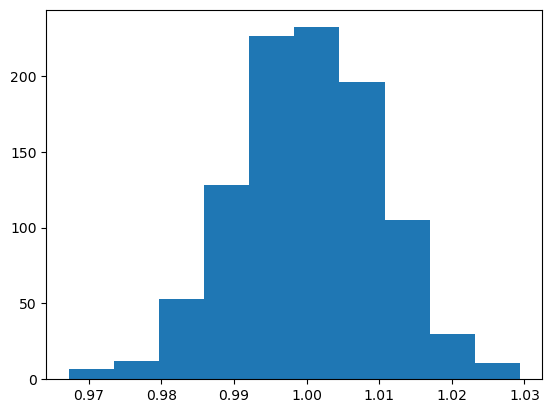

In [13]:
# if you want to see this
%matplotlib inline
plt.hist(co2_exc.random_sample(n=1000))

In [14]:
# this in case you want to try with normal dist
#from stats_arrays import NormalUncertainty

#co2_exc['uncertainty type'] = NormalUncertainty.id
#co2_exc['loc'], co2_exc['scale'] = 1, 0.01
#co2_exc.save()
#co2_exc.uncertainty  # check that
#co2_exc.as_dict()  # OK

#  Now MC simulation

Sources here: [example](http://stackoverflow.com/questions/38532146/obtaining-distribution-of-results-from-lcia), [another example](https://brightwaylca.org/examples/getting-started.html), and [source code](https://bitbucket.org/cmutel/brightway2-calc/src/662740694a8c70074105b5dca45b58651adb5eb5/bw2calc/monte_carlo.py?at=default&fileviewer=file-view-default)

In [15]:
# Check again that uncertainty info is stored
list(el.exchanges())[0].uncertainty

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [16]:
bd.methods

Methods dictionary with 763 objects, including:
	('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
	('CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
	('CML v4.8 2016', 'ecotoxicity: freshwater', 'freshwater aquatic ecotoxicity (FAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: marine', 'marine aquatic ecotoxicity (MAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: terrestrial', 'terrestrial ecotoxicity (TETP inf)')
	('CML v4.8 2016', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels')
	('CML v4.8 2016', 'eutrophication', 'eutrophication (fate not incl.)')
	('CML v4.8 2016', 'human toxicity', 'human toxicity (HTP inf)')
	('CML v4.8 2016', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
	('CML v4.8 2016', 'ozone depletion', 'ozone layer depletion (ODP steady state)')
Use `list(this object)` to get the complete list.

In [17]:
# This is the montecarlo simulation
mc = bc.LCA(demand={el: 1000}, method=method_key, use_distributions=True)
mc.lci()
mc.lcia()
mc_results = [mc.score for _ in zip(range(500), mc)]

# two things here:
# 1. zip() returns a zip object, which is an iterator of tuples, for instance:
    # a = (1, 2, 3)
    # b = ('a', 'b', 'c')
    # for i in zip(a, b):
    #     print(i) 
    # # output will be: 
    #     # (1, 'a')
    #     # (2, 'b')
    #     # (3, 'c')

# 2. using a fuction within [ ] usig a for loop is called a "list comprehension". The result is a list

In [18]:
mc_results[1:10] # printing the first 10 elements on the list...remember, the deterministic value was 80

[79.50210708224306,
 80.99534928575756,
 78.95088478313002,
 80.5851765539663,
 80.58204704061026,
 80.36525157762239,
 79.65938344219373,
 78.346672403521,
 81.26881394227175]

Text(0.5, 0, 'lca.score')

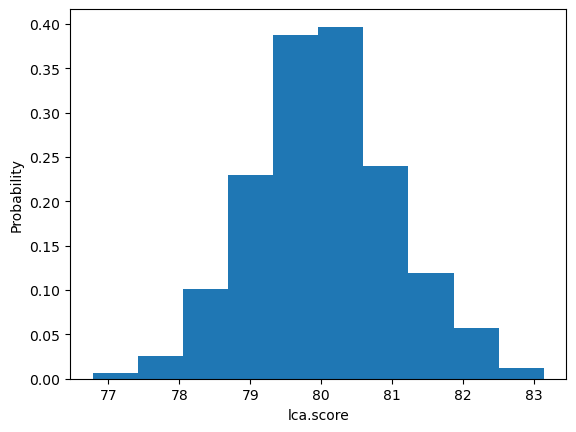

In [19]:
# Look at the MC results
plt.hist(mc_results, density=True)  # From matplotlib package. Use bins = int(500/15) to increase number of bars
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [20]:
print(np.mean(mc_results)) # from numpy package
print(np.median(mc_results)) # from numpy package
print(lca.score) # the deterministic value, we are very close to the mean and median

80.05288722441462
80.01327502554832
80.0


In [21]:
pd.DataFrame(mc_results).describe()  # from pandas package

,0
count,500.000000
mean,80.052887
std,0.987863
min,76.781469
25%,79.406440
50%,80.013275
75%,80.684619
max,83.134242


Text(0.5, 0, 'lca.score')

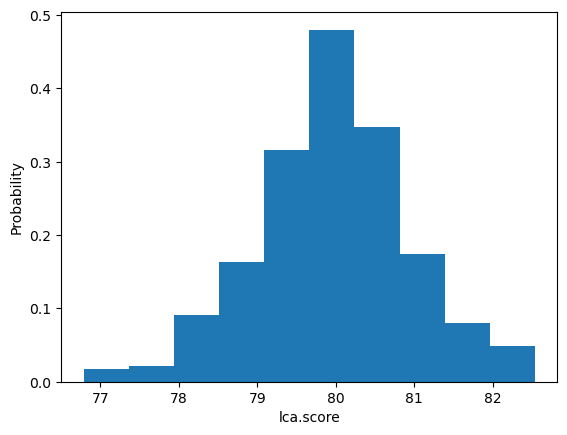

In [22]:
# Do this again and compare results
mc2 = bc.LCA(demand={el: 1000}, method=method_key, use_distributions=True)
mc.lci()
mc.lcia()
mc2_results = [mc.score for _ in zip(range(500), mc)]

plt.hist(mc2_results, density=True)
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [23]:
print(np.mean(mc2_results))
print(np.median(mc2_results))
print(lca.score)

79.9660241204723
79.98194909762185
80.0


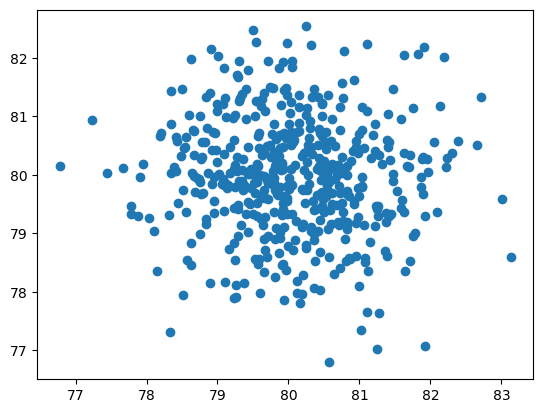

In [24]:
plt.scatter(mc_results, mc2_results) # Correct. Do you understand why?

In [25]:
# Another way to do it
iterations = 1000
scores = np.zeros(iterations)  # 1-dimensional array filled with zeros
for iteration in range(iterations):
    next(mc)
    scores[iteration] = mc.score
for i in range(1, 10):
    print(scores[i])  # need the zero because one-dimensional array

78.72860228773821
80.75101172321467
80.7786516952175
79.35274650329657
79.51457741445219
78.64232911291373
79.97411246916815
79.8580287898877
78.61923814426521


In [26]:
# Another way, get a list instead of an array
iterations = 1000
scores = []
for iteration in range(iterations):
    next(mc)
    scores.append(mc.score)
for i in range(1, 10):
    print(scores[i])
type(scores) == type(mc_results)  # same type of results as in the first case

79.27595595098258
77.83408578376321
80.43307393262977
79.71006920266707
81.34215232433391
81.18734600516143
80.3031516304004
81.89676602361766
80.80541382728832


True